[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana3/2_LSTM_Bitcoin.ipynb)



# Descripción del problema

Datos originales: https://challengedata.ens.fr/participants/challenges/31/

El problema trata de buscar un algoritmo de clasificación que ayude a crear estrategias de inversión en criptomonedas, basado en el "sentimiento" extraído de noticias y redes sociales.

Por cada hora de trading se contabilizó la ocurrencia de algunos terminos, tales como 'adoption' y 'hack', en un selecto numero de cuentas influyentes de twitter y en algunos foros como 'Bitcointalk'.

Se han creado 10 temas diferentes, algunos positivos y otros negativos y se han contabilizado las palabras antes mencionadas, antes de una normalización.

Dado un tema y un tema, hemos visto los conteos de las últimas 48 horas y se estandarizaron esos conteos. El resultado se multiplicó por el conteo promedio por hora y se dividió por el conteo promedio por hora de todo el entrenamiento

Para un tiempo T en el periodo de tiempo i, con lag k ($k\in[\![0;47]\!]$) el valor F ode la característica será:

$$
F_{i,k}=\frac{T_{i,k}-\overline{T_{i}}}{\sqrt{\frac{1}{47}\sum\limits_{j=0}^{47}{(T_{i,j}-\overline{T_{i}})^{2}}}}*\frac{\overline{T_i}}{\overline{T}} 
$$


Se agregaron 5 características correspondientes a los precios finales en periodos de 1 hr, 6 hrs, 12 hrs, 24 hrs y 48 hrs
El objetivo es predecir si el precio del Bitcoin tendrá un retorno (en la próxima hora) que sea de mas del 0.2%, entre -0.2% y 0.2% o menos al -0.2%.

La métrica utilizada para la perdida es la perdida logistica, definita como el negativo de la log-verosimilitud de las etiquetas verdaderas comparadas con las probabilidades predichas por el clasificador.

Las verdaderas etiquetas están codificadas como una matríz de 3 columnas, donde hay unos o ceros dependiendo si el elemento pertenece a la categoría de una columna u otra.
 
Dada una matriz P de probabilidades $p_{i,k}=Pr(t_{i,k}=1)'$ , la función de perdida se define como

$$
L_{log}(Y,P)=-log{Pr(Y|P)}=-\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^3{y_{i,k}log(p_{i,k})}
$$

Entre más bajo el score de ésta medida, mejor.



# Dependencias

In [ ]:
# !pip install -U plotly

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers

import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funciones

In [ ]:
def evaluate_model(estimator, train, val, test):
    print('train cross_entropy = ', estimator.evaluate(train[0], train[1], verbose = False))
    print('  val cross_entropy = ', estimator.evaluate(val[0], val[1], verbose = False))
    print(' test cross_entropy = ', estimator.evaluate(test[0], test[1], verbose = False))

In [ ]:
# TODO: Modificar para seleccionar características cambiando n_features, no sólo las primeras n_features
# TODO: Revisar los resultados generados cuando se seleccionan distintos parámetros
# NOTE: Asuma que el dataframe tiene 5 X, y 48 columnas para cada una de las 10 I ordenadas de reciente a antigua
def transform_dataframe(df, len_prices = 5, n_features = 10, len_features = 48):
    if type(len_prices) != int or type(n_features) != int or type(len_features) != int:
        raise ValueError(f'Los parámetros len_prices, n_features y len_features deben ser de tipo int. Recibibo {type(len_prices)},{type(n_features)} y {type(len_features)}')

    assert 0 < len_prices <= 5, 'len_prices debe estar entre 1 y 5'
    assert 0 < n_features <= 10, 'n_features debe estar entre 1 y 10'
    assert 0 < len_features <= 48, 'len_features debe estar entre 1 y 48'

    df.reset_index(inplace = True, drop = True)
    
    # Los nombres de las columnas están al reves para tener primer la observación más antigua
    prices_cols = ['X5', 'X4', 'X3', 'X2', 'X1']

    prices = np.zeros((len(df), len_prices, 1))
    features = np.zeros((len(df), len_features, n_features))

    for i in range(len(df)):
        # Se transforman la forma de los precios
        prices[i] = df.loc[i, prices_cols[-len_prices:]].values.reshape((len_prices, 1))
        # Para cada característica
        for j in range(n_features):
            # Se obtiene los 48 rezagos y se voltea el arreglo para tener el más antiguo primero
            # Aquí se aplica el supuesto de que el dataframe tiene 5 columnas de 5
            features[i, :, j] = np.flip(df.iloc[i, 5+48*j:5+len_features + 48*j].values)
    return prices, features

> The Input data contains 10 time series of 48 trading hours representing complementary features based on sentiment analysis from news extracted from twitter or forums like Bitcointalk on Bitcoin, and 5 time series based on the variation of Bitcoin price during the past 1, 6, 12, 24 and 48 hours normalised by volatility during the period. Input data, for training and testing, will be given by a .csv file, whose first line contains the header. Then each line corresponds to a sample, each column to a feature. The features are the following:

>- ***ID***: Id of the sample which is linked to the ID of the output file;
- ***I_1_lag(k)*** to ***I_10_lag(k)***: Values of Indicators *I_1* to *I_10* for each k lag ($k\in[\![0;47]\!]$) representing the normalized value of Indicators *I_1* to *I_10* each hour of the past 48 trading hours;
- ***X_1*** to ***X_5***: Values of 5 normalised indicators representing price variation of Bitcoin on the last 1, 6, 12, 24 and 48 hours.

> There will be 14 000 samples for the train set and 5 000 for the test set. For a given sample, the time series (for the 10 sentiment indicators) are given over the same 48 trading hours.

>The training outputs are given in a .csv file. Each line corresponds to a sample:

>- ***ID***: Id of the sample;
- ***Target_-1***: classification of the return of Bitcoin in the next hour. -1 signifies a down move of less than -0.2%;
- ***Target_0***: classification of the return of Bitcoin in the next hour. 0 signifies a move between -0.2% and 0.2%;
- ***Target_1***: classification of the return of Bitcoin in the next hour. 1 signifies a up move of more than 0.2%.



In [ ]:
X_raw = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana7/input_training_IrTAw7w.csv').set_index('ID')
X_raw

,X1,X2,X3,X4,X5,I1_lag0,I1_lag1,I1_lag2,I1_lag3,I1_lag4,...,I10_lag38,I10_lag39,I10_lag40,I10_lag41,I10_lag42,I10_lag43,I10_lag44,I10_lag45,I10_lag46,I10_lag47
ID,,,,,,,,,,,,,,,,,,,,,
0,0.460020,0.620360,-0.972192,2.745197,4.177783,2.325865,2.060138,0.071162,2.360597,-0.611526,...,-0.342912,-0.194165,0.122331,0.028682,-0.093626,-0.559840,0.562584,-0.557868,1.424906,-0.016294
1,-0.347872,-2.199925,-0.222026,3.741888,8.608291,-4.091293,-3.502499,-1.463631,0.383153,-3.669962,...,1.261341,-0.082428,-1.035813,-0.249607,-0.971215,-0.058408,1.460632,-0.653394,-1.743487,4.065305
2,-2.152963,-0.432461,1.619057,-0.003912,3.870262,-0.598858,-0.412391,-0.765354,-0.998152,-0.938755,...,2.245204,3.002347,2.674186,2.656251,1.062974,-0.484619,-0.044594,1.579731,0.962836,1.146983
3,-1.827669,-1.881770,-4.214322,0.178225,0.992362,0.383757,2.512478,-0.383434,-0.208506,-1.104289,...,1.383203,-1.338892,0.298076,1.808275,2.837975,2.054112,0.741138,1.701911,0.110082,0.114980
4,0.748761,1.799939,1.561006,5.204120,2.161637,-1.275226,-1.544131,-1.802590,-1.128526,-0.469835,...,-0.477313,0.742923,-0.273225,1.311015,0.744330,2.914322,1.030602,0.480722,-0.492838,1.377958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-0.074522,-0.472044,-2.860659,-1.266230,-10.229167,0.583145,-0.051301,-0.584659,1.458945,2.004759,...,-1.634290,-1.527111,-1.008016,-0.500519,1.277636,1.257714,0.502732,1.751844,0.150679,-0.533808
13996,1.730118,3.177408,0.816198,1.136877,-1.588960,1.011735,-0.185748,-0.522647,2.316802,1.219339,...,-0.409750,0.840944,-1.804313,0.357944,-1.058557,-0.196874,-2.507582,0.125756,1.532976,-1.087343
13997,2.093028,4.108092,1.056253,8.163642,8.916299,2.338713,2.554397,1.665492,3.719985,-0.278893,...,-0.531223,-1.249847,-1.288419,-0.897649,-0.199824,-0.033545,0.240647,2.188396,0.039340,0.756515


In [ ]:
X_raw.loc[:,'I1_lag0':'I1_lag47']

,I1_lag0,I1_lag1,I1_lag2,I1_lag3,I1_lag4,I1_lag5,I1_lag6,I1_lag7,I1_lag8,I1_lag9,...,I1_lag38,I1_lag39,I1_lag40,I1_lag41,I1_lag42,I1_lag43,I1_lag44,I1_lag45,I1_lag46,I1_lag47
ID,,,,,,,,,,,,,,,,,,,,,
0,2.325865,2.060138,0.071162,2.360597,-0.611526,-0.474029,1.380300,0.160847,1.101279,-1.064275,...,-0.785555,-1.098086,-0.958669,-0.718184,-0.614667,-0.438390,2.786918,-0.510293,-0.807482,0.123301
1,-4.091293,-3.502499,-1.463631,0.383153,-3.669962,-2.118337,-0.933734,0.279289,-2.170922,-0.578250,...,2.282263,5.016641,2.104728,0.163865,-1.294264,-0.933024,2.169507,-1.596210,1.111491,1.389198
2,-0.598858,-0.412391,-0.765354,-0.998152,-0.938755,-0.890084,-0.435971,-0.589324,-1.261406,-1.702031,...,0.536822,0.715479,1.589677,1.278546,1.678936,0.758068,0.783552,0.789617,1.355588,1.560763
3,0.383757,2.512478,-0.383434,-0.208506,-1.104289,-1.055666,-1.792361,-1.313026,-1.183724,-2.461788,...,-0.498264,-2.369554,-1.817159,0.813002,-0.645045,3.332806,-0.737482,3.840992,0.214112,0.766485
4,-1.275226,-1.544131,-1.802590,-1.128526,-0.469835,-1.033174,-1.132530,0.673757,-0.899913,-0.816432,...,2.109324,1.729324,-0.340226,0.508742,1.909086,1.259342,9.463993,-0.684622,-0.358928,2.419920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.583145,-0.051301,-0.584659,1.458945,2.004759,-0.188567,-1.174885,-0.524965,0.918840,-0.832003,...,-1.943652,-0.782297,0.123417,-1.385554,1.179859,1.596327,3.081927,1.616732,-0.439906,1.212270
13996,1.011735,-0.185748,-0.522647,2.316802,1.219339,-0.112632,4.439025,3.193461,1.082060,0.664259,...,-1.066735,-2.032352,-1.797870,-1.732067,-0.104588,-1.871567,-1.317764,-0.837187,-0.500197,0.627397
13997,2.338713,2.554397,1.665492,3.719985,-0.278893,-0.313868,1.106249,0.659270,-0.838686,-2.130881,...,-1.332451,1.324859,1.210238,1.003666,-2.557547,-1.720577,-0.418486,-0.354826,-1.154290,-0.430326


In [ ]:
y_raw = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana7/output_training_F2dZW38.csv').set_index('ID')
y_raw

,Target -1,Target 0,Target 1
ID,,,
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
13995,0,0,1
13996,0,1,0
13997,0,1,0


## División: Entrenamiento, Validación y Prueba

In [ ]:
# Division para entrenamiento de red LSTM
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size = .8, random_state = 10, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = .75, random_state = 10, shuffle = False)

print('     Train shape', X_train.shape)
print('Validation shape', X_val.shape)
print('      Test shape', X_test.shape)

     Train shape (8400, 485)
Validation shape (2800, 485)
      Test shape (2800, 485)


## Transformaciones

In [ ]:
# Longitud de la serie de tiempo de variaciones de los precios del Bitcoin X_i
len_prices = 5

# Cantidad de temas vistos
n_features = 10
# Cantidad de tiempos que vemos hacia atras en las variables de sentimiento
len_features = 48

train_prices, train_features = transform_dataframe(X_train, len_prices, n_features, len_features)
val_prices, val_features     = transform_dataframe(X_val,   len_prices, n_features, len_features)
test_prices, test_features   = transform_dataframe(X_test,  len_prices, n_features, len_features)

In [ ]:
train_prices[0]

array([[ 4.17778324],
       [ 2.74519725],
       [-0.97219231],
       [ 0.62035968],
       [ 0.46002033]])

In [ ]:
train_prices.shape

(8400, 5, 1)

In [ ]:
train_features[0][:, 0]

array([ 0.12330096, -0.80748226, -0.51029275,  2.78691821, -0.4383897 ,
       -0.61466708, -0.71818432, -0.95866944, -1.09808579, -0.78555544,
       -1.22302101, -0.88165666, -1.09750822, -0.84122588,  0.25120809,
        0.90708829, -1.08424554, -1.07812114, -0.70310434, -0.37712057,
        1.55133108,  1.05576805,  0.209699  ,  1.76036892, -0.30387588,
        0.07121708,  0.97642094,  0.07843654, -0.35526931,  0.22145519,
        0.06140576, -0.07898419, -0.73271442, -1.22189031, -0.62196393,
        0.49002681, -1.57032042,  0.24734582, -1.06427504,  1.10127919,
        0.16084683,  1.3802998 , -0.47402934, -0.6115262 ,  2.36059748,
        0.07116183,  2.06013838,  2.3258649 ])

In [ ]:
X_raw.loc[:,'I1_lag0':'I1_lag47']

,I1_lag0,I1_lag1,I1_lag2,I1_lag3,I1_lag4,I1_lag5,I1_lag6,I1_lag7,I1_lag8,I1_lag9,...,I1_lag38,I1_lag39,I1_lag40,I1_lag41,I1_lag42,I1_lag43,I1_lag44,I1_lag45,I1_lag46,I1_lag47
ID,,,,,,,,,,,,,,,,,,,,,
0,2.325865,2.060138,0.071162,2.360597,-0.611526,-0.474029,1.380300,0.160847,1.101279,-1.064275,...,-0.785555,-1.098086,-0.958669,-0.718184,-0.614667,-0.438390,2.786918,-0.510293,-0.807482,0.123301
1,-4.091293,-3.502499,-1.463631,0.383153,-3.669962,-2.118337,-0.933734,0.279289,-2.170922,-0.578250,...,2.282263,5.016641,2.104728,0.163865,-1.294264,-0.933024,2.169507,-1.596210,1.111491,1.389198
2,-0.598858,-0.412391,-0.765354,-0.998152,-0.938755,-0.890084,-0.435971,-0.589324,-1.261406,-1.702031,...,0.536822,0.715479,1.589677,1.278546,1.678936,0.758068,0.783552,0.789617,1.355588,1.560763
3,0.383757,2.512478,-0.383434,-0.208506,-1.104289,-1.055666,-1.792361,-1.313026,-1.183724,-2.461788,...,-0.498264,-2.369554,-1.817159,0.813002,-0.645045,3.332806,-0.737482,3.840992,0.214112,0.766485
4,-1.275226,-1.544131,-1.802590,-1.128526,-0.469835,-1.033174,-1.132530,0.673757,-0.899913,-0.816432,...,2.109324,1.729324,-0.340226,0.508742,1.909086,1.259342,9.463993,-0.684622,-0.358928,2.419920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.583145,-0.051301,-0.584659,1.458945,2.004759,-0.188567,-1.174885,-0.524965,0.918840,-0.832003,...,-1.943652,-0.782297,0.123417,-1.385554,1.179859,1.596327,3.081927,1.616732,-0.439906,1.212270
13996,1.011735,-0.185748,-0.522647,2.316802,1.219339,-0.112632,4.439025,3.193461,1.082060,0.664259,...,-1.066735,-2.032352,-1.797870,-1.732067,-0.104588,-1.871567,-1.317764,-0.837187,-0.500197,0.627397
13997,2.338713,2.554397,1.665492,3.719985,-0.278893,-0.313868,1.106249,0.659270,-0.838686,-2.130881,...,-1.332451,1.324859,1.210238,1.003666,-2.557547,-1.720577,-0.418486,-0.354826,-1.154290,-0.430326


In [ ]:
train_features.shape

(8400, 48, 10)

In [ ]:
print('        Labels: (samples, sequence length, features)')
print('  Train prices:', train_prices.shape)
print('Train features:', train_features.shape)

        Labels: (samples, sequence length, features)
  Train prices: (8400, 5, 1)
Train features: (8400, 48, 10)


# Algoritmos-Modelos

## Regresión logística

El punto de referencia de los propietarios de los datos es una regresión logística tomando como características X1, $\dots$, X5.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
np.set_printoptions(suppress=True)
train_prices

array([[[ 4.17778324],
        [ 2.74519725],
        [-0.97219231],
        [ 0.62035968],
        [ 0.46002033]],

       [[ 8.60829058],
        [ 3.74188805],
        [-0.22202592],
        [-2.19992478],
        [-0.34787206]],

       [[ 3.87026224],
        [-0.00391238],
        [ 1.61905739],
        [-0.43246086],
        [-2.15296262]],

       ...,

       [[-8.01161549],
        [-3.25267826],
        [-3.23511161],
        [-4.42009744],
        [-1.64528608]],

       [[-5.7431553 ],
        [-4.55756999],
        [-4.1314012 ],
        [-4.21510083],
        [ 0.26622901]],

       [[ 3.53645002],
        [ 6.40746335],
        [ 0.75612526],
        [ 1.8952313 ],
        [ 1.59236659]]])

In [ ]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_raw, y_raw, train_size = .8, random_state = 10, shuffle = False)

In [ ]:
X_train_0 = X_train_0[['X1', 'X2', 'X3', 'X4', 'X5']]
X_train_0

,X1,X2,X3,X4,X5
ID,,,,,
0,0.460020,0.620360,-0.972192,2.745197,4.177783
1,-0.347872,-2.199925,-0.222026,3.741888,8.608291
2,-2.152963,-0.432461,1.619057,-0.003912,3.870262
3,-1.827669,-1.881770,-4.214322,0.178225,0.992362
4,0.748761,1.799939,1.561006,5.204120,2.161637
...,...,...,...,...,...
11195,-0.197817,-0.503618,-5.999348,-7.625040,-2.796258
11196,0.511663,1.874224,0.079970,2.570751,7.507616
11197,3.405716,4.082560,5.426551,4.861720,10.263339


In [ ]:
X_test_0 = X_test_0[['X1', 'X2', 'X3', 'X4', 'X5']]
X_test_0

,X1,X2,X3,X4,X5
ID,,,,,
11200,-0.214679,3.356129,4.749172,5.709250,1.351358
11201,-1.192837,0.957475,-0.430136,-2.751596,6.960146
11202,0.450306,-0.061307,0.284349,2.194250,-3.470744
11203,0.169981,0.180298,5.055600,3.872075,7.453231
11204,0.223090,-0.213792,4.367535,4.579829,6.908846
...,...,...,...,...,...
13995,-0.074522,-0.472044,-2.860659,-1.266230,-10.229167
13996,1.730118,3.177408,0.816198,1.136877,-1.588960
13997,2.093028,4.108092,1.056253,8.163642,8.916299


In [ ]:
y_train_0

,Target -1,Target 0,Target 1
ID,,,
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
11195,1,0,0
11196,1,0,0
11197,0,1,0


In [ ]:
y_train_0 = y_train_0.idxmax(axis=1)
y_train_0

ID
0         Target 1
1        Target -1
2         Target 1
3        Target -1
4         Target 0
           ...    
11195    Target -1
11196    Target -1
11197     Target 0
11198    Target -1
11199     Target 1
Length: 11200, dtype: object

In [ ]:
y_test_0 = y_test_0.idxmax(axis=1)
y_test_0

ID
11200    Target 1
11201    Target 1
11202    Target 0
11203    Target 0
11204    Target 0
           ...   
13995    Target 1
13996    Target 0
13997    Target 0
13998    Target 1
13999    Target 0
Length: 2800, dtype: object

In [ ]:
model_0 = LogisticRegression(multi_class='multinomial', random_state=1)

In [ ]:
model_0

LogisticRegression(multi_class='multinomial', random_state=1)

In [ ]:
model_0.fit(X_train_0, y_train_0 )

LogisticRegression(multi_class='multinomial', random_state=1)

In [ ]:
y_pred_0 = model_0.predict(X_test_0)

In [ ]:
(y_pred_0 == y_test_0).sum() / len(y_pred_0)

0.3914285714285714

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_0, y_pred_0))

              precision    recall  f1-score   support

   Target -1       0.40      0.26      0.32       869
    Target 0       0.39      0.44      0.41       985
    Target 1       0.39      0.46      0.42       946

    accuracy                           0.39      2800
   macro avg       0.39      0.39      0.38      2800
weighted avg       0.39      0.39      0.39      2800



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

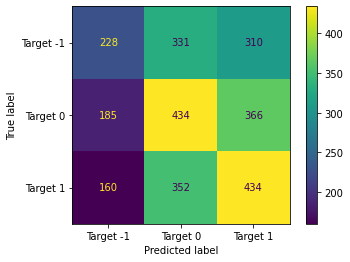

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_0, y_pred_0)

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
# Otra salida útil del modelo
model_0.predict_proba(X_test_0)

array([[0.33511418, 0.36160748, 0.30327834],
       [0.32165475, 0.32061938, 0.35772587],
       [0.32411655, 0.35737579, 0.31850767],
       ...,
       [0.37148466, 0.34819785, 0.28031748],
       [0.3457555 , 0.35425792, 0.29998658],
       [0.31150756, 0.33277062, 0.35572182]])

In [ ]:
y_test_0

ID
11200    Target 1
11201    Target 1
11202    Target 0
11203    Target 0
11204    Target 0
           ...   
13995    Target 1
13996    Target 0
13997    Target 0
13998    Target 1
13999    Target 0
Length: 2800, dtype: object

In [ ]:
log_loss(y_test_0, model_0.predict_proba(X_test_0))

1.0933753077377295

## Redes Neuronales

#### Callbacks

In [ ]:
# Los guarda en GoogleDrive, si no se quiere hacer la conexión, entonces cambiar la ruta o quitar el callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     filepath = 'checkpoints', 
#     save_best_only = True
# )

earlystop_cb = keras.callbacks.EarlyStopping(
    patience = 25, 
    restore_best_weights = True
)

### Primera Aquitectura (Solo utilizando Caracteristicas de Bitcoin)

#### Aquitectura

In [ ]:
# Definicion de las capas
price_input = layers.Input(shape = (len_prices, 1), name = 'price_input')
price_normalization = layers.Normalization(name = 'price_normalization', axis = 1)
price_lstm = layers.LSTM(32, name = 'price', 
                        # kernel_regularizer=keras.regularizers.l1_l2(l1 = 1e-1, l2 = 1e-1),
                         return_sequences=True, 
                         )

price_lstm2 = layers.LSTM(16, name='price2')

# Como se conectan las capas definidas arriba
price_normalized = price_normalization(price_input)
price_output = price_lstm(price_normalized)
price_output2 = price_lstm2(price_output)

# Como se conecta lo posterior
prediction_layer = keras.models.Sequential(
    [
     layers.Dense(32, activation = 'relu'), 
     layers.Dense(32, activation = 'relu'), 
     layers.Dense(32, activation = 'relu'), 
     layers.Dense(3, activation = 'softmax')
    ], 
    name = 'prediction'
)
prediction_output = prediction_layer(price_output2) 


#### Modelo

In [ ]:
# Instanciación del objeto modelo
model = keras.Model(price_input, prediction_output)

model.compile(
    loss = 'categorical_crossentropy'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 price_input (InputLayer)    [(None, 5, 1)]            0         
                                                                 
 price_normalization (Normal  (None, 5, 1)             11        
 ization)                                                        
                                                                 
 price (LSTM)                (None, 5, 32)             4352      
                                                                 
 price2 (LSTM)               (None, 16)                3136      
                                                                 
 prediction (Sequential)     (None, 3)                 2755      
                                                                 
Total params: 10,254
Trainable params: 10,243
Non-trainable params: 11
________________________________________________________

##### Visualización

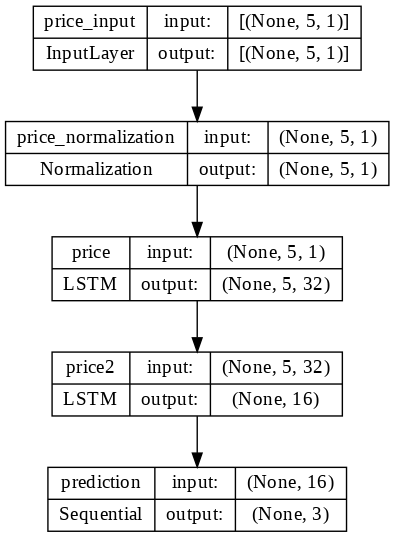

In [ ]:
# Visualización del modelo
keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=100,
)

#### Entrenamiento

In [ ]:
history = model.fit(
    train_prices, y_train,
    batch_size = 128,
    epochs = 1000,  # Valor real de 1000 
    callbacks = [earlystop_cb], 
    validation_data = [val_prices, y_val]
).history

Epoch 1/1000
66/66 [==============================] - 9s 21ms/step - loss: 1.0966 - val_loss: 1.0926
Epoch 2/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0923 - val_loss: 1.0923
Epoch 3/1000
66/66 [==============================] - 1s 8ms/step - loss: 1.0907 - val_loss: 1.0867
Epoch 4/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0895 - val_loss: 1.0872
Epoch 5/1000
66/66 [==============================] - 1s 8ms/step - loss: 1.0892 - val_loss: 1.0844
Epoch 6/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0890 - val_loss: 1.0842
Epoch 7/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0876 - val_loss: 1.0890
Epoch 8/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0880 - val_loss: 1.0829
Epoch 9/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0873 - val_loss: 1.0824
Epoch 10/1000
66/66 [==============================] - 0s 7ms/step - loss: 1.0869 - val_loss: 1.085

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss']))

fig.show()

#### Métricas

In [ ]:
evaluate_model(model, [train_prices, y_train], [val_prices, y_val], [test_prices, y_test])

train cross_entropy =  1.084877371788025
  val cross_entropy =  1.0824486017227173
 test cross_entropy =  1.084473967552185


In [ ]:
y_pred_prob = model.predict(test_prices)

88/88 [==============================] - 1s 2ms/step


In [ ]:
y_pred_prob

array([[0.33357474, 0.3786665 , 0.28775877],
       [0.29394418, 0.3178653 , 0.38819054],
       [0.3017893 , 0.40751785, 0.29069287],
       ...,
       [0.35595405, 0.28901786, 0.35502806],
       [0.34771928, 0.31903353, 0.33324724],
       [0.29503003, 0.4180266 , 0.28694338]], dtype=float32)

In [ ]:
y_pred = y_pred_prob.argmax(axis=1)
y_pred

array([1, 2, 1, ..., 0, 0, 1])

In [ ]:
y_test_f = y_test.idxmax(axis=1).map({'Target -1': 0, 'Target 0': 1, 'Target 1': 2})

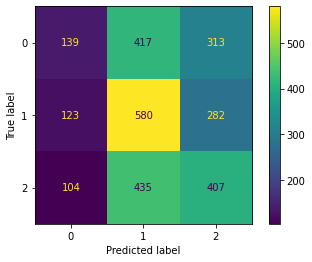

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred)

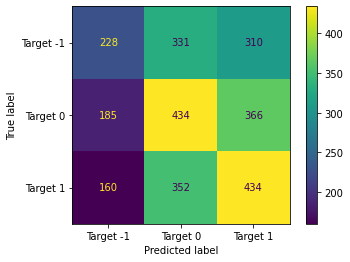

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_0, y_pred_0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_f, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.16      0.23       869
           1       0.41      0.59      0.48       985
           2       0.41      0.43      0.42       946

    accuracy                           0.40      2800
   macro avg       0.40      0.39      0.37      2800
weighted avg       0.40      0.40      0.38      2800



### Segunda Arquitectura

#### Arquitectura

In [ ]:
fusion_dim = 8

price_input = layers.Input(shape = (len_prices,), name = 'price_input')

price_layer = keras.models.Sequential(
    [
     layers.Normalization(name = 'price_normalization'), 
     layers.Dense(8, activation = 'tanh'), 
     layers.Dense(8, activation = 'relu'),
     layers.Dense(8, activation = 'tanh'), 
     layers.Dense(fusion_dim, activation = 'relu'),
    ], 
    name = 'price'
)

price_output = price_layer(price_input)

sentiment_input = layers.Input(shape = (len_features, n_features), name = 'sentiment_input')
sentiment_normalization = layers.Normalization(name = 'sentiment_normalization', axis = 1)
sentiment_lstm = layers.LSTM(fusion_dim, name = 'sentiment')

sentiment_normalized = sentiment_normalization(sentiment_input)
sentiment_output = sentiment_lstm(sentiment_normalized)

fusion = layers.Multiply(name = 'hadamard_product')([sentiment_output, price_output])

prediction_layer = keras.models.Sequential(
    [
     layers.Dense(8, activation = 'tanh'), 
     layers.Dense(8, activation = 'relu'), 
     layers.Dense(8, activation = 'sigmoid'), 
     layers.Dense(3, activation = 'softmax')
    ], 
    name = 'prediction'
)
prediction_output = prediction_layer(fusion)

#### Modelo

In [ ]:
model_2 = keras.Model([price_input, sentiment_input], prediction_output)

model_2.compile(
    loss = 'categorical_crossentropy'
)

model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentiment_input (InputLayer)   [(None, 48, 10)]     0           []                               
                                                                                                  
 sentiment_normalization (Norma  (None, 48, 10)      97          ['sentiment_input[0][0]']        
 lization)                                                                                        
                                                                                                  
 price_input (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 sentiment (LSTM)               (None, 8)            608         ['sentiment_normalization[0

##### Visualización

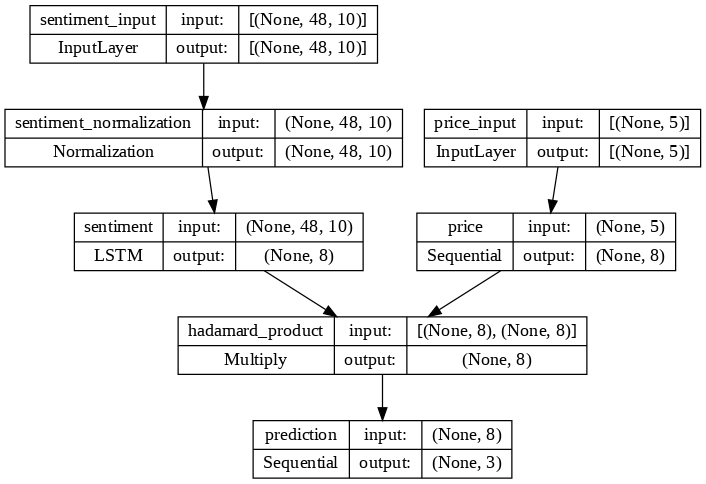

In [ ]:
keras.utils.plot_model( 
    model_2,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=90,
)

#### Entrenamiento

In [ ]:
history = model_2.fit(
    [train_prices, train_features], y_train, 
    epochs = 30, # Original, 1000 épocas
    callbacks = [earlystop_cb], 
    validation_data = [[val_prices, val_features], y_val]
).history

Epoch 1/30
263/263 [==============================] - 5s 11ms/step - loss: 1.1083 - val_loss: 1.0927
Epoch 2/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0874 - val_loss: 1.0812
Epoch 3/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0724 - val_loss: 1.0680
Epoch 4/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0585 - val_loss: 1.0570
Epoch 5/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0499 - val_loss: 1.0532
Epoch 6/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0443 - val_loss: 1.0503
Epoch 7/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0402 - val_loss: 1.0485
Epoch 8/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0364 - val_loss: 1.0484
Epoch 9/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0335 - val_loss: 1.0491
Epoch 10/30
263/263 [==============================] - 2s 9ms/step - loss: 1.0314 - val_loss: 1.047

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss'])) \
   .update_layout(hovermode = 'x')

fig.show()

#### Métricas

In [ ]:
evaluate_model(model_2, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  1.0018469095230103
  val cross_entropy =  1.0487550497055054
 test cross_entropy =  1.0557115077972412


## Guardando el mejor modelo

In [ ]:
model_2.save('best_model.h5')

# Cargar el modelo guardado

In [ ]:
best_model = keras.models.load_model('best_model.h5')
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentiment_input (InputLayer)   [(None, 48, 10)]     0           []                               
                                                                                                  
 sentiment_normalization (Norma  (None, 48, 10)      97          ['sentiment_input[0][0]']        
 lization)                                                                                        
                                                                                                  
 price_input (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 sentiment (LSTM)               (None, 8)            608         ['sentiment_normalization[0

In [ ]:
evaluate_model(best_model, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  1.0018469095230103
  val cross_entropy =  1.0487550497055054
 test cross_entropy =  1.0557115077972412


# Resumen

Respecto a la segunda arquitectura:

1. Fue la que tuvo mejores resultados con entropía cruzada de $0.9843$, $1.0256$ y $1.0329$ para los conjuntos de entrenamiento, validación y prueba, respectivamente.
2. Tardó menos épocas en entrenar



# Ejercicios

1. Crear un nuevo modelo ya sea haciendo modificaciones a alguna de las arquitecturas presentes, o comenzando desde cero. Escriba sus observaciones comparando el resultado con el mejor la Segunda Arquitectura. Como sugerencia, puede probar cambiando los datos de entrada, las capas de las redes secuenciales, la fusión de los datos, agregando regularización o dropout, callbacks, etc. 
2. ¿Cómo haría la predicción para nuevos valores?

3. Cree las matrices de confusión para la última red neuronal, así como el classification report.
